## ***Natural Languagem Processing*** to predict if a headline from a news website contains sarcasm - **Data Modeling**.

In this file, there will the data modeling to get a model to predict the data and to be evaluated.

For the data modeling, **two approaches** will be used, the first one uses the **words frequency** difference between the target classes along with the **row's word count** and the second one uses a **neural network *word embedding* method** with `keras` to extract a **pattern** from the data.

In [108]:
import pandas as pd, numpy as np, scikit_posthocs as sp, matplotlib.pyplot as plt, seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils import resample

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier

In [ ]:
# Constants names

SAMPLE_FRACTION = 0.03
TEST_SIZE = 0.33
LOWER_BOUND_CONFIDENCE_INTERVAL = 2.5
UPPER_BOUND_CONFIDENCE_INTERVAL = 97.5

sns.set_style("darkgrid")

In [3]:
sarcasm_df = pd.read_csv('sarcasm.csv')

sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Feature Engineering

At first, in order to **soften the training computational costs** and, especifically, **optimize tasks as hyperparameters tunning**, a separated sample `X_train_sampled` along with the labels `y_train_sampled` with **3%** of the rows from the training dataset is created, therefore, assuming a **similar data distribution** between the entire training set and the sample extracted by giving a **probability of choice in the sample equivalent to the original proportion** in the dataset, the training step will have the **same class representativity** and **less computational costs**.

In [80]:
X, y = sarcasm_df['headline'], sarcasm_df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=42, 
                                                    stratify=y
                                                )

train_data = pd.concat([X_train, y_train], axis=1)

class_counts = sarcasm_df['is_sarcastic'].value_counts(normalize=True)
train_data['weights'] = train_data['is_sarcastic'].map(class_counts)

sampled_data = train_data.sample(frac=SAMPLE_FRACTION, random_state=42, weights='weights')

X_train_sampled, y_train_sampled = sampled_data['headline'], sampled_data['is_sarcastic']

scv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

At this moment, as the first **feature engineering approach**, the **word frequency difference between each target class** along with the **rows word count**, multipying both values, made with `CountVectorizer`, are used to obtain a numerical set of features.

So, the feature ***i*** related to a especific token in the row ***j*** will be given as:

$$
Feature_{ij} = (token_{i}\_count_{class = \textbf{non\_sarcastic}} - token_i\_count_{class = \textbf{sarcastic}}) \times (token_i\_count)_j
$$

Therefore, **the tokens with more appearances in sarcastic rows will have a greater positive value** and, on the other hand, **tokens with more appearances in sarcastic rows will have a negative value** and, in addiction to that, the **row's token count will enhance the frequency discrimination**.

In [5]:
vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_train_sampled_vectorized = vectorizer.transform(X_train_sampled)
X_test_vectorized = vectorizer.transform(X_test)

X_train_df = pd.DataFrame(
    X_train_vectorized.toarray(),
    columns=vectorizer.get_feature_names_out()
)

X_sampled_train_df = pd.DataFrame(
    X_train_sampled_vectorized.toarray(),
    columns=vectorizer.get_feature_names_out()
)
    
X_test_df = pd.DataFrame(
    X_test_vectorized.toarray(),
    columns=vectorizer.get_feature_names_out()
)

class_0_counts = X_train_df[y_train.reset_index(drop=True) == 0].sum()
class_1_counts = X_train_df[y_train.reset_index(drop=True) == 1].sum()

word_diff = class_0_counts - class_1_counts

word_weights = dict(zip(word_diff.index, word_diff.values))

X_train_weighted = X_train_df.multiply(
    X_train_df.columns.map(word_weights),
    axis=1
)

X_train_sampled_weighted = X_sampled_train_df.multiply(
    X_sampled_train_df.columns.map(word_weights),
    axis=1
)

X_test_weighted = X_test_df.multiply(
    X_test_df.columns.map(word_weights),
    axis=1
)

In order to **soften the features scale difference**, the ***standand scaler*** will be applied, so, the `StandardScaler` will be fitted on the training dataset only to **prevent data leak** and, after, both training and test sets will be transformed by the *standardization*.

In [115]:
stantard = StandardScaler()

X_train_weighted = stantard.fit_transform(X_train_weighted)
X_train_sampled_weighted = stantard.transform(X_train_sampled_weighted)
X_test_weighted = stantard.transform(X_test_weighted)

In [117]:
X_train_weighted.shape

(17895, 21094)

### Model training

The models will be trained with the ***Naive Bayes*** and the ***Random Forest algorithms***, both using the ***grid search*** method to make the **hyperparameter tunning** with the `StratifiedKFold` technique to maintain the **original classes proportion**.

Knowing that the dataset has a level of imbalance, the scoring method to be used will be the `f1_weighed`, which deals with precision and recall problems with class weights.

In [ ]:
NB_model = BernoulliNB()

NB_param_grid = {
    'alpha': [0.5, 0.75, 1.0, 2.0]
}

NB_grid = GridSearchCV(
    estimator=NB_model,
    param_grid=NB_param_grid,
    cv=scv,
    n_jobs=2
)

The model is first **trained with the samples** and, with the **best parameters**, trained with the **entire training set** later

In [74]:
NB_grid.best_params_

{'alpha': 0.5}

In [75]:
NB_best = NB_grid.best_estimator_.fit(X_train_weighted, y_train)

In [10]:
print(classification_report(y_train, NB_best.predict(X_train_weighted), digits=3))

print(classification_report(y_test, NB_best.predict(X_test_weighted), digits=3))

              precision    recall  f1-score   support

           0      0.940     0.961     0.950     10040
           1      0.949     0.921     0.935      7855

    accuracy                          0.944     17895
   macro avg      0.944     0.941     0.943     17895
weighted avg      0.944     0.944     0.944     17895

              precision    recall  f1-score   support

           0      0.835     0.895     0.864      4945
           1      0.852     0.774     0.811      3869

    accuracy                          0.842      8814
   macro avg      0.844     0.834     0.838      8814
weighted avg      0.843     0.842     0.841      8814



* According to the `classification_report`, the **accuracy** reached a good accuracy level, ***84%***, along with solid values of **precision** and **recall**, except on the sarcastic headlines recall, but, the model presented a high ***overfitting*** degree, pointed by the **accuracy variance between the training and the test sets**.

So, to handle the ***overfitting***, the PCA method will be used to **simplificate the model** and decrease the complexity.

In [11]:
pca = PCA(n_components=2000)

X_train_pca = pca.fit_transform(X_train_weighted)

X_test_pca, X_train_sampled_pca = pca.transform(X_test_weighted), pca.transform(X_train_sampled_weighted)

The number of resulting components on the dataset will be calculated taking as a reference the number of rows on the training set and the number of features ratio.

So, the dataset previously had a ratio:

$$
\frac{\#\_rows}{\#\_features} = \frac{17895}{21094} = 0.85
$$

And then, in order to keep the ratio close to ten times than previously:

$$
\#\_features = \frac{17895}{10} \approx 2000
$$

In [69]:
NB_model = BernoulliNB()

NB_param_grid = {
    'alpha': [0.5, 0.75, 1.0, 2.0]
}

NB_grid_pca = GridSearchCV(
    estimator=NB_model,
    param_grid=NB_param_grid,
    cv=scv,
    n_jobs=2,
    scoring='f1_weighted'
).fit(X_train_sampled_pca, y_train_sampled)

In [71]:
NB_grid_pca.best_params_

{'alpha': 0.5}

In [72]:
NB_best_pca = NB_grid.best_estimator_.fit(X_train_pca, y_train)

In [ ]:
print(classification_report(y_train, NB_best_pca.predict(X_train_pca), digits=3))

print(classification_report(y_test, NB_best_pca.predict(X_test_pca), digits=3))

              precision    recall  f1-score   support

           0      0.837     0.804     0.820     10040
           1      0.762     0.799     0.780      7855

    accuracy                          0.802     17895
   macro avg      0.799     0.802     0.800     17895
weighted avg      0.804     0.802     0.802     17895

              precision    recall  f1-score   support

           0      0.825     0.787     0.806      4945
           1      0.743     0.787     0.764      3869

    accuracy                          0.787      8814
   macro avg      0.784     0.787     0.785      8814
weighted avg      0.789     0.787     0.787      8814



* According to the `classification_report`, the **overffiting was smoothed**, pointed by the **smaller difference between tes and training accuracies**, but the accuracy has decreased, indicating that the **irreducible error** by the data of the algorithm might **limit the model efficiency**.

Now, to check **other algorithms efficiency** on the task, the ***Random Forest*** model id trained on the dataset.

In [16]:
RF_model = RandomForestClassifier(n_jobs=2, verbose=0)

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'log_loss', 'entropy'],
    'class_weight': [None, 'balanced']
}

RF_grid = GridSearchCV(
                estimator=RF_model,
                param_grid=RF_param_grid,
                cv=scv,
                n_jobs=2,
                scoring='f1_weighted',
                verbose=0
            ).fit(X_train_sampled_weighted, y_train_sampled)

In [17]:
RF_grid.best_params_

{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 50}

In [18]:
RF_best = RF_grid.best_estimator_.fit(X_train_weighted, y_train)

In [19]:
print(classification_report(y_train, RF_best.predict(X_train_weighted), digits=3))

print(classification_report(y_test, RF_best.predict(X_test_weighted), digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     10040
           1      1.000     1.000     1.000      7855

    accuracy                          1.000     17895
   macro avg      1.000     1.000     1.000     17895
weighted avg      1.000     1.000     1.000     17895

              precision    recall  f1-score   support

           0      0.840     0.805     0.822      4945
           1      0.764     0.804     0.783      3869

    accuracy                          0.805      8814
   macro avg      0.802     0.805     0.803      8814
weighted avg      0.806     0.805     0.805      8814



* Based on the report, despite the reasonable accuracy and score, the model shows a high **overfitting** degree as well.

Therefore, to deal with overfitting, constraints are set for the model in the hyperparameter grid.

In [20]:
RF_model = RandomForestClassifier(n_jobs=2, class_weight='balanced', n_estimators=200, verbose=0)

RF_param_grid = {
    'max_depth': [2000, 1000, 500],
    'min_samples_leaf': [5, 4, 3]
}

RF_grid = GridSearchCV(
                estimator=RF_model,
                param_grid=RF_param_grid,
                cv=scv,
                n_jobs=2,
                scoring='f1_weighted'
            ).fit(X_train_sampled_weighted, y_train_sampled)

In [21]:
RF_grid.best_params_

{'max_depth': 1000, 'min_samples_leaf': 3}

In [22]:
RF_best = RF_grid.best_estimator_.fit(X_train_weighted, y_train)

In [23]:
print(classification_report(y_train, RF_best.predict(X_train_weighted), digits=3))

print(classification_report(y_test, RF_best.predict(X_test_weighted), digits=3))

              precision    recall  f1-score   support

           0      0.897     0.833     0.864     10040
           1      0.805     0.878     0.840      7855

    accuracy                          0.853     17895
   macro avg      0.851     0.856     0.852     17895
weighted avg      0.857     0.853     0.853     17895

              precision    recall  f1-score   support

           0      0.860     0.777     0.816      4945
           1      0.746     0.839     0.790      3869

    accuracy                          0.804      8814
   macro avg      0.803     0.808     0.803      8814
weighted avg      0.810     0.804     0.805      8814



* Based on the results, the **overfitting** degree was smoothed, but the **accuracy has not changed significantly**, which also indicates a high **irreducible error** by the data to the **Random Forest** algorithm.

In order to verify the **tokens discrimination ratio**, the **model's features relevance graph** is plotted.

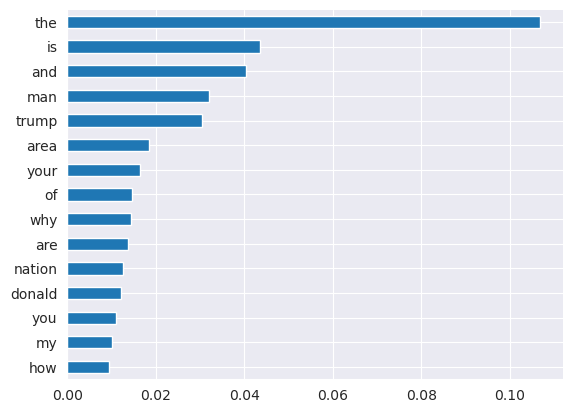

In [24]:
feat_importances = pd.Series(RF_best.feature_importances_, index=X_train_df.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh')

sns.despine()
plt.show()

* According to the graph, the symbol '**the**' demonstrated a high **degree of discrimination in sarcasm**, along with '**and**' and '**is**', highlighting '**man**' as the most discriminating noun.

### **Neural Networks embedding**

On the second feature engineering approach, the **neural network word embedding** method with `keras` will be used.

Therefore, the headlines are converted to **tokens** with the built-in library functions and a **convolutional neural network** is designed with a ***embedding layer*** to handle the unstructured data and middle layers to process the information, find patterns and make the prediction.

In [81]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_nn, X_test_nn = tokenizer.texts_to_sequences(X_train), tokenizer.texts_to_sequences(X_test)

sequences = X_train_nn + X_test_nn

vocab_size = len(tokenizer.word_index) + 1  

max_len = max(len(seq) for seq in sequences)

X_train_nn = pad_sequences(X_train_nn, maxlen=max_len, padding='post')
X_test_nn = pad_sequences(X_test_nn, maxlen=max_len, padding='post')

Same as previously, the dataset is splitted in **samples** to **optmize the training step**.

In [82]:
train_data = pd.DataFrame({'X': list(X_train_nn), 'is_sarcastic': y_train.tolist()})

sampled_data = train_data.groupby('is_sarcastic')[['X', 'is_sarcastic']].apply(
    lambda group: group.sample(frac=SAMPLE_FRACTION, random_state=42)
)

X_train_sampled, y_train_sampled = np.array(sampled_data['X'].tolist()), np.array(sampled_data['is_sarcastic'])

At this moment, a grid search is made with the neural network to find the best params among **regularization rates**, **batch sizes** and **epochs**.

The initial **embedding shape** have a **input dimension** of **5 features**.

In [83]:
def create_model(vocab_size, embedding_dim, input_length, learning_rate=0.001, dropout_rate=0.5, l2_rate=0.05, **kwargs):
    model = Sequential([
        Input(shape=(input_length,)),  
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Flatten(),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate / 3),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate / 6),
        Dense(1, activation='sigmoid') 
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

sequence_length = X_train_nn.shape[1]

keras_model = KerasClassifier(
    model=create_model,
    model__vocab_size=vocab_size,         
    model__embedding_dim=5,               
    model__input_length=sequence_length,  
    verbose=0
)

param_grid = {
    'model__l2_rate': [0.01, 0.001], 
    'model__dropout_rate': [0.1, 0.3],
    'fit__batch_size': [16, 24],     
    'fit__epochs': [20, 50]         
}

grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=scv, scoring='f1_weighted')

grid_result = grid.fit(X_train_sampled, y_train_sampled)

In [84]:
grid_result.best_params_

{'fit__batch_size': 16,
 'fit__epochs': 20,
 'model__dropout_rate': 0.3,
 'model__l2_rate': 0.001}

In [85]:
NN_best = grid_result.best_estimator_.fit(X_train_nn, y_train)

In [86]:
print(classification_report(y_train, NN_best.predict(X_train_nn), digits=3))

print(classification_report(y_test, NN_best.predict(X_test_nn), digits=3))

              precision    recall  f1-score   support

           0      0.998     1.000     0.999     10040
           1      1.000     0.997     0.998      7855

    accuracy                          0.999     17895
   macro avg      0.999     0.998     0.999     17895
weighted avg      0.999     0.999     0.999     17895

              precision    recall  f1-score   support

           0      0.819     0.846     0.832      4945
           1      0.794     0.760     0.777      3869

    accuracy                          0.808      8814
   macro avg      0.806     0.803     0.804      8814
weighted avg      0.808     0.808     0.808      8814



* The model has shown a high **overfitting** level despite a good accuracy and consistent values of **recall** and **precision**.

In order to check the **embedding input shape** influence on the **overfitting** degree and on the **model efficiency**, the dimension is changed to values in the interval of **[5, 50]** and the **accuracy values** are plotted.

In [ ]:
def fit_nn_model(embedding_dim, best_params):
    model = create_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,  
    input_length=sequence_length,
    learning_rate=0.001,  
    dropout_rate=best_params['model__dropout_rate'],  
    l2_rate=best_params['model__l2_rate']  
)
   
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(
            X_train_nn, y_train,
            batch_size=best_params['fit__batch_size'],  
            epochs=best_params['fit__epochs'],  
            validation_split=0.2,  
            verbose=0
        )

    return accuracy_score(y_train, model.predict(X_train_nn).round()), accuracy_score(y_test, model.predict(X_test_nn).round())

In [ ]:
results = {k: fit_nn_model(k, grid_result.best_params_) for k in range(5, 51, 5)}

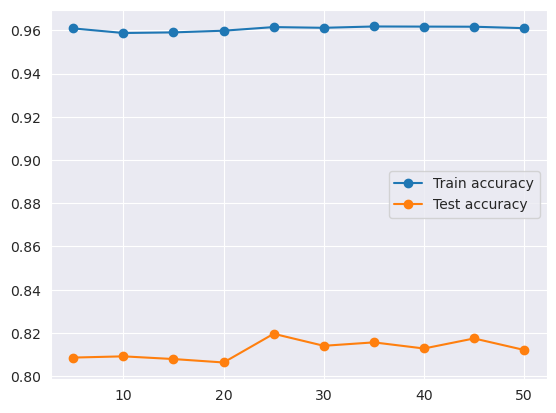

In [123]:
plt.plot(results.keys(), [acc[0] for acc in results.values()], marker='o', label='Train accuracy')
plt.plot(results.keys(), [acc[1] for acc in results.values()], marker='o',  label='Test accuracy')
plt.legend()

plt.show()

* According to the image, the **overffiting occurs on input shapes between 5 and 50**, showing **consistent accuracy levels**. Therefore, **the network topology might be not as efficent as ideal**.

To check the models **statistical significance** and **discrepancy**, a ***booststrap resampling*** task is applied to both three models built and the ***Friedman*** test is aplied on a **cross validation score** modeling task to verify if the models has differences between eachother.

In [95]:
def get_bootstrap_confidences(model, X_test, y_test, iterations=100):
    accuracies, baseline_accuracy = [], accuracy_score(y_test, model.predict(X_test))

    for _ in range(iterations):
        X_test_resample, y_test_resample = resample(X_test, y_test)

        y_pred_resampled = model.predict(X_test_resample)

        acc = accuracy_score(y_test_resample, y_pred_resampled)
        accuracies.append(acc)

    bootstrap_mean = np.mean(accuracies)
    bootstrap_std_error = np.std(accuracies, ddof=1)

    print(f"Bootstrap mean: {bootstrap_mean:.4f}")
    print(f"Standard error: {bootstrap_std_error:.4f}")

    lower_bound = np.percentile(accuracies, LOWER_BOUND_CONFIDENCE_INTERVAL)
    upper_bound = np.percentile(accuracies, UPPER_BOUND_CONFIDENCE_INTERVAL)
    
    print(f"Confidence interval (95%): [{lower_bound:.4f}, {upper_bound:.4f}]")

    plt.hist(accuracies, bins=30, alpha=0.7, color='blue')
    plt.axvline(lower_bound, color='red', linestyle='--', label='Lower bound')
    plt.axvline(upper_bound, color='green', linestyle='--', label='Upper bound')
    plt.axvline(baseline_accuracy, color='black', linestyle='-', label='Baseline accuracy')
    plt.legend()
    plt.show()

Bootstrap mean: 0.8423
Standard error: 0.0041
Confidence interval (95%): [0.8349, 0.8507]


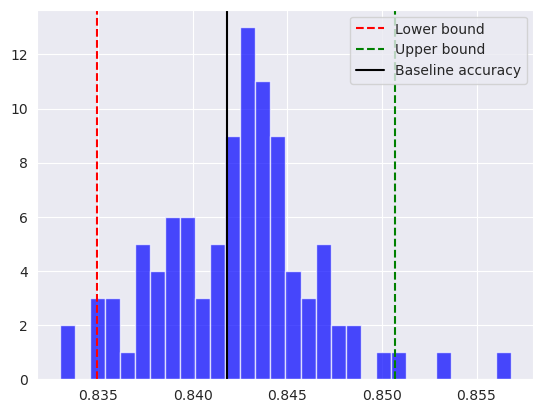

In [97]:
get_bootstrap_confidences(NB_best, X_test_weighted, y_test)

Bootstrap mean: 0.8043
Standard error: 0.0041
Confidence interval (95%): [0.7955, 0.8124]


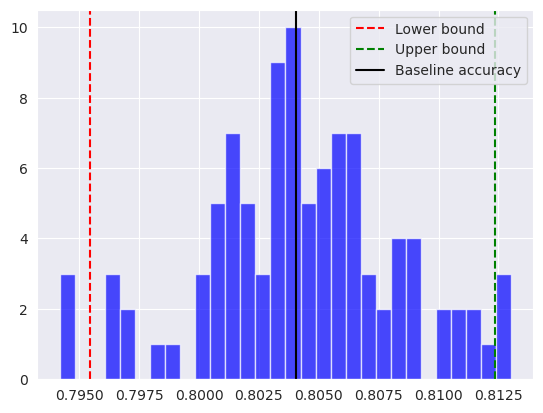

In [98]:
get_bootstrap_confidences(RF_best, X_test_weighted, y_test)

Bootstrap mean: 0.8090
Standard error: 0.0039
Confidence interval (95%): [0.8012, 0.8165]


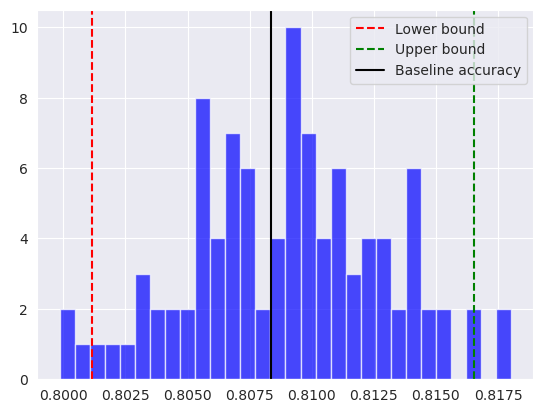

In [96]:
get_bootstrap_confidences(NN_best, X_test_nn, y_test)

* Based on the images above, all models have **reasonable bias**, having *weighted f1* values between **80%** and **85%**, and ***variance*** values, concentrating accuracy samples **close to the baseline accuracy**. Therefore, the models have shown a **good effiency** on predicting the sarcasm on the dataset given the **56%-44% imbalance**.

At this moment, the ***Friedman*** and ***Nemenyi*** tests is applied to check how **distinct** the models are between eachother relatively to the given **predicted labels**.

In [109]:
scores_nb = cross_val_score(NB_best, X_test_weighted, y_test, scoring='f1_weighted', cv=5)
scores_rf = cross_val_score(RF_best, X_test_weighted, y_test, scoring='f1_weighted', cv=5)
scores_nn = cross_val_score(NN_best, X_test_nn, y_test, scoring='f1_weighted', cv=5)

scores = np.array([scores_nb, scores_rf, scores_nn]).T 

nemenyi_results = sp.posthoc_nemenyi_friedman(scores)

print(nemenyi_results)

          0         1         2
0  1.000000  0.012310  0.139405
1  0.012310  1.000000  0.609411
2  0.139405  0.609411  1.000000


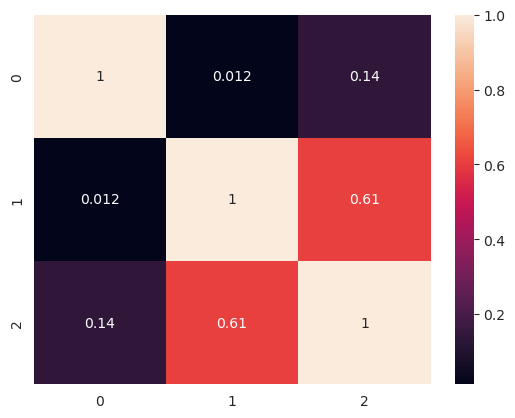

In [113]:
sns.heatmap(nemenyi_results, annot=True)

"""
1: Naive Bayes
2: Random Forest
3: Neural Network Embedding
"""

plt.show()

* According to the graph, it is clear that the **most distinct models** are, in pairs, ***Naive Bayes*** and ***Random Forest*** and ***Naive Bayes*** and ***Neural Networks***, indicating that the ***Naive Bayes*** algorithm has a more **efficient adjustment** on the data set.

Therefore, among all the trained models, it is possible to assume that the ***Naive Bayes*** algorithm presented a better behavior and handling on the data, showing the best **accuracy** and ***weighted f1*** value and is the **most different constructed model** among those examined.

### Conclusion

According to the modeling step, extracting discriminant features from titles is a very **feasible and efficient task** if well applied with machine learning tools and dataset manipulation. Thus, with an overall accuracy of ***~85%*** on the test set and **consistent recall and precision values** ​​without neglecting either class. **Naive Bayes** algorithm with a ***Bernoulli*** distribution emerged as the best-fit model to the dataset and the most distinctive model according to the ***Friedman*** and **bootstrap accuracy permutation tests**, with a confidence interval (95%) of accuracy **[0.8349, 0.8507]**.

Therefore, the answer to the main question is: **yes**, it is possible to extract nice discriminant features from a human-readable text to obtain a reasonable prediction efficiency in a natural language processing task, either in a "*heuristic*" way, with the **frequency difference** between the observations of the target classes together with the **word count** in a line, or with a **neural network word embedding method**, despite the higher consumption of processing power.